# A Diffusion Model from Scratch in Pytorch

이 노트북에서 저는 자동차 이미지를 생성하기 위한 매우 간단한(가능한 한 적은 코드) 확산 모델을 만들고 싶습니다. YouTube 동영상에서 모든 이론적 세부 사항을 설명합니다.


**Sources:**
- Youtube Link [Diffusion models from scratch in PyTorch](https://www.youtube.com/watch?v=a4Yfz2FxXiY)
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

데이터 세트로 우리는 기차 세트에서 약 8000개의 이미지로 구성된 StandordCars 데이터 세트를 사용합니다. 이것이 좋은 결과를 얻기에 충분한지 봅시다.

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting stanford_cars/cars_train.tgz to stanford_cars


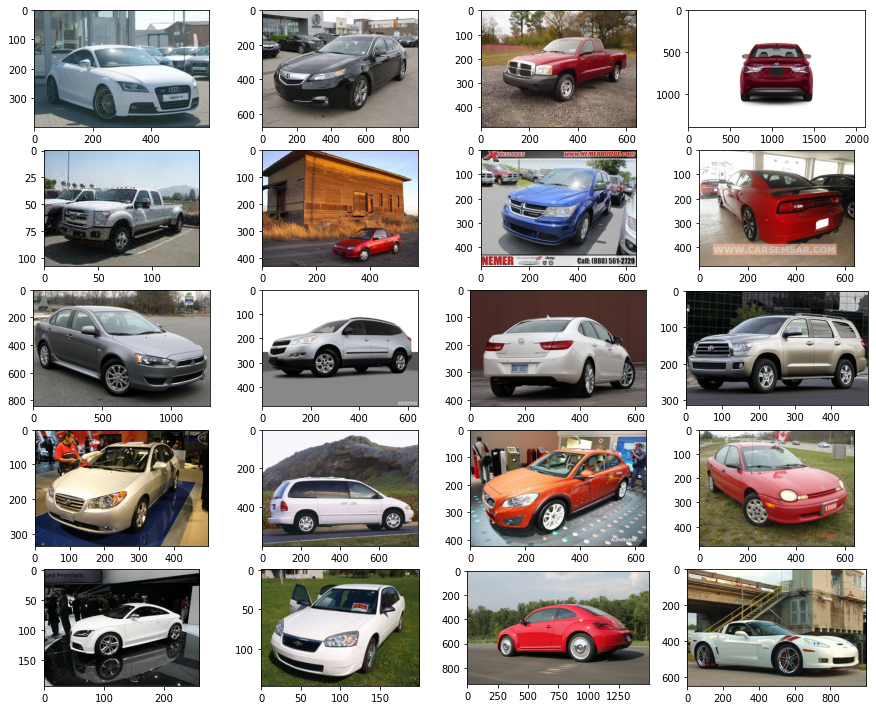

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(num_samples/cols + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.StanfordCars(root=".", download=True)
show_images(data)

이 노트북의 뒷부분에서 우리는 이 데이터 세트에 대해 몇 가지 추가 수정을 수행할 것입니다. 예를 들어 이미지를 더 작게 만들고 텐서로 변환하는 등의 작업을 수행합니다.

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




먼저 점점 더 노이즈가 많은 이미지인 모델에 대한 입력을 빌드해야 합니다. 이 작업을 순차적으로 수행하는 대신 논문에 제공된 닫힌 형식을 사용하여 모든 시간 단계에 대한 이미지를 개별적으로 계산할 수 있습니다.

**Key Takeaways**:
- 소음 수준/분산은 미리 계산할 수 있습니다.
- 변동 일정에는 다양한 유형이 있습니다.
- 각 타임스텝 이미지를 독립적으로 샘플링할 수 있습니다(가우스 합계도 가우시안임).
- 이 진행 단계에서는 모델이 필요하지 않습니다.

In [2]:
import torch.nn.functional as F

def linear_beta_schedule(timestep, start=0.0001, end=0.02):
    return torch.linspace(start, end, timestep)


def get_index_from_list(vals, t, x_shape):
    '''
    배치 차원을 고려하면서.
    전달된 값 목록의 특정 인덱스 t를 반환합니다.   
    '''
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape)- 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device="cpu"):
    '''
    이미지와 시간 단계를 입력으로 사용하고
    노이즈 버전을 반환합니다.
    '''
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )    
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timestep=T)


# Pre-calculate different terms for closed from
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0/ alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

데이터 세트에서 테스트해 봅시다 ...

In [3]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Using downloaded and verified file: stanford_cars/car_devkit.tgz
Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting stanford_cars/cars_test.tgz to stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

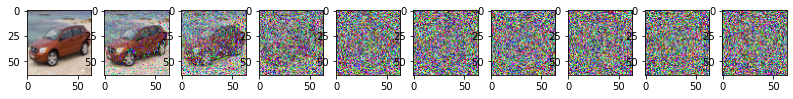

In [4]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Step 2: The backward process = U-Net



UNets에 대한 훌륭한 소개는 https://amaarora.github.io/2020/09/13/unet.html 게시물을 참조하십시오.


**주요 사항**:
- 이미지의 노이즈를 예측하기 위해 간단한 형태의 UNet을 사용합니다.
- 입력은 노이즈 이미지, 출력은 이미지의 노이즈
- 매개변수는 전체 시간에 걸쳐 공유되기 때문에 우리는 우리가 어떤 타임스텝에 있는지 네트워크에 알려야 합니다.
- Timestep은 변환기 Sinusoidal Embedding에 의해 인코딩됩니다.
- 분산이 고정되어 있기 때문에 하나의 단일 값(평균)을 출력합니다.

In [5]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    '''
    Sinusoidal  Position  Embeddings
    정현파          위치        임베이딩
    '''
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**구현할 수 있는 추가 개선 사항:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**주요 사항:**
- 약간의 수학 후에 우리는 매우 간단한 손실 함수로 끝납니다.
- L2 손실 요법과 같은 다른 가능한 선택이 있습니다.

In [6]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- @torch.no_grad()를 추가하지 않으면 pytorch가 그래디언트 계산을 위해 모든 이전 이미지를 고정하기 때문에 메모리가 빨리 부족합니다.
- Forward pass에 대한 noise variance를 미리 계산해 두었기 때문에 순차적으로 backward 과정을 수행할 때도 이를 사용해야 합니다.

In [7]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    모델을 호출하여 이미지의 노이즈를 예측하고 반환합니다.
    노이즈가 제거된 이미지.
    아직 마지막 단계에 있지 않은 경우 이 이미지에 노이즈를 적용합니다.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i/stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

## Training

Epoch 0 | step 000 Loss: 0.8134061694145203 


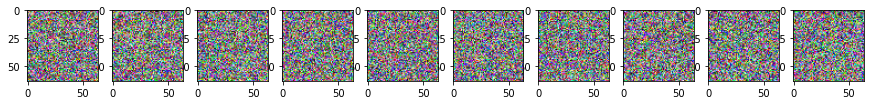

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

표 2에서는 역공정 매개변수화 및 교육의 샘플 품질 효과를 보여줍니다.
목표(섹션 3.2). μ를 예측하는 기본 옵션은 다음과 같은 경우에만 잘 작동합니다.
가중되지 않은 평균 제곱 오차 대신 실제 변이 한계에 대해 훈련됨, 단순화된 목표
식과 비슷하다. (14). 우리는 또한 (매개변수화된
대각선 Σθ(xt)을 변형 경계로) 불안정한 학습 및 샘플 품질 저하로 이어짐
고정 분산에 비해. 예측은 우리가 제안한 대로 다음과 같이 대략적으로 수행됩니다.
고정된 분산이 있는 변이 경계에서 학습할 때 μ~를 예측하지만 학습할 때 훨씬 더 좋습니다.
우리의 단순화된 목표로.

diffusion 모델은 각 순방향 프로세스 단계에서 데이터를 축소합니다(√
1 - βt 인자)
노이즈를 추가할 때 분산이 증가하지 않도록 하여 일관되게 스케일링된 입력을 제공합니다.
신경망 역 과정에. NCSN은 이 배율 인수를 생략합니다.